In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from scipy.fft import irfft, rfft, rfftfreq
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas as pd
import os
import pywt
from scipy.ndimage import gaussian_filter1d, maximum_filter
from scipy.signal import find_peaks

from helper_funcs import *
from findpeaks import findpeaks

ModuleNotFoundError: No module named 'findpeaks'

In [2]:
# First navigate to our directory
directory_path = os.path.join("Data", "processed_df.parquet")
# Load the dataframe
df = pd.read_parquet(directory_path)
# Get frequncy axis
f = rfftfreq(32768, 1/44100)[0:8192]

In [3]:
index = 2000
spectrum = df.iloc[index]['spectrum']

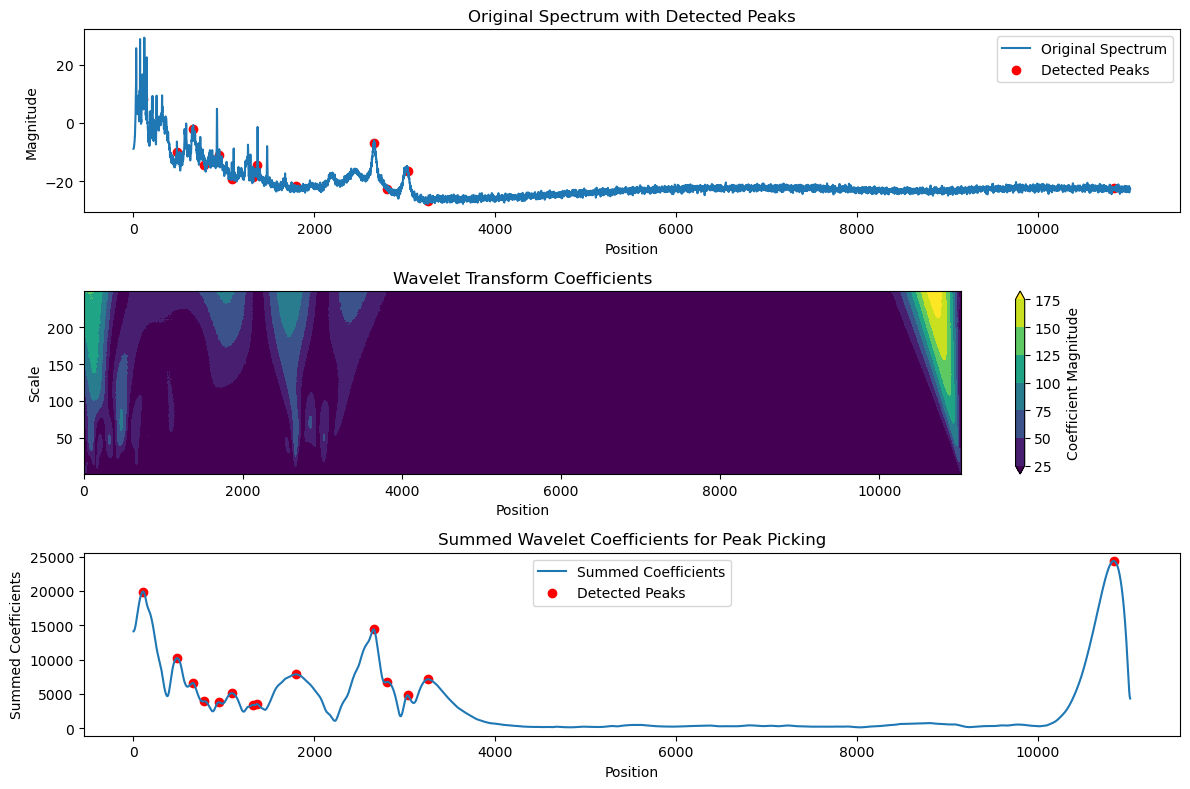

Detected peak positions: [  106.32019043   481.80541992   656.76269531   784.61608887
   943.42346191  1086.08093262  1321.6003418   1368.70422363
  1799.36828613  2655.31311035  2808.73718262  3030.79833984
  3258.24279785 10841.96777344]


In [ ]:
# 1D Summed Coefficient Peak Picking

# Wavelet transform
wavelet = 'mexh'  # Mexican Hat wavelet, good for peak detection
scales = np.arange(1, 250)  # Choose scales based on expected peak widths
coefficients, frequencies = pywt.cwt(spectrum, scales, wavelet)

# Take the absolute value of the coefficients
coefficients = np.abs(coefficients)

# Sum across scales to enhance peak prominence
summed_coefficients = np.sum(coefficients, axis=0)

# Smooth the summed coefficients with gaussian filter
sigma = 10
summed_coefficients = gaussian_filter1d(summed_coefficients, sigma)

# Find peaks using scipy.signal.find_peaks
peaks, properties = find_peaks(summed_coefficients, height=1000, distance=10)

# Plot the results
plt.figure(figsize=(12, 8))

# Original spectrum with detected peaks
plt.subplot(3, 1, 1)
plt.plot(f, spectrum, label="Original Spectrum")
plt.scatter(f[peaks], spectrum[peaks], color='red', label="Detected Peaks")
plt.title("Original Spectrum with Detected Peaks")
plt.xlabel("Position")
plt.ylabel("Magnitude")
plt.legend()

# Wavelet coefficients heatmap
plt.subplot(3, 1, 2)
plt.contourf(f, scales, coefficients, extend='both', cmap='viridis')
plt.title("Wavelet Transform Coefficients")
plt.xlabel("Position")
plt.ylabel("Scale")
plt.colorbar(label="Coefficient Magnitude")

# Summed coefficients and detected peaks
plt.subplot(3, 1, 3)
plt.plot(f, summed_coefficients, label="Summed Coefficients")
plt.scatter(f[peaks], summed_coefficients[peaks], color='red', label="Detected Peaks")
plt.title("Summed Wavelet Coefficients for Peak Picking")
plt.xlabel("Position")
plt.ylabel("Summed Coefficients")
plt.legend()

plt.tight_layout()
plt.show()

# Print detected peak positions
print("Detected peak positions:", f[peaks])


In [4]:
# 2D persistent homology wavelet coefficient peak picking
from findpeaks import findpeaks
# Wavelet transform
wavelet = 'mexh'  # Mexican Hat wavelet, good for peak detection
scales = np.arange(1, 250)  # Choose scales based on expected peak widths
coefficients, frequencies = pywt.cwt(spectrum, scales, wavelet)

# Take the absolute value of the coefficients to get magnitude
coefficients = np.abs(coefficients)

# Find peaks using the findpeaks library
fp = findpeaks(method='topology')
results = fp.fit(coefficients)

# Get peak coordinates
peaks_2d = results['persistence_peaks']

# Convert peak indices to meaningful positions and scales
if len(peaks_2d) > 0:
    peak_positions = np.array(peaks_2d)
    peak_scales = scales[peak_positions[:, 0]]
    peak_positions_f = f[peak_positions[:, 1]]

# Plot the results
plt.figure(figsize=(12, 10))

# Original spectrum with detected peaks
plt.subplot(3, 1, 1)
plt.plot(f, spectrum, label="Original Spectrum")
if len(peaks_2d) > 0:
    plt.scatter(peak_positions_f, spectrum[np.searchsorted(f, peak_positions_f)], color='red', label="Detected Peaks")
plt.title("Original Spectrum with Detected Peaks")
plt.xlabel("Position")
plt.ylabel("Magnitude")
plt.legend()

# Wavelet coefficients heatmap with detected peaks
plt.subplot(3, 1, 2)
plt.contourf(f, scales, coefficients, extend='both', cmap='viridis')
if len(peaks_2d) > 0:
    plt.scatter(peak_positions[:, 1], peak_positions[:, 0], color='red', label="Detected Peaks")
plt.title("Wavelet Transform Coefficients with Detected Peaks")
plt.xlabel("Position")
plt.ylabel("Scale")
plt.colorbar(label="Coefficient Magnitude")
plt.legend()

# Highlight detected peaks on summed coefficients for comparison
summed_coefficients = np.sum(coefficients, axis=0)
plt.subplot(3, 1, 3)
plt.plot(f, summed_coefficients, label="Summed Coefficients")
if len(peaks_2d) > 0:
    plt.scatter(peak_positions_f, summed_coefficients[np.searchsorted(f, peak_positions_f)], color='red', label="Detected Peaks")
plt.title("Summed Wavelet Coefficients for Comparison")
plt.xlabel("Position")
plt.ylabel("Summed Coefficients")
plt.legend()

plt.tight_layout()
plt.show()

# Print detected peak positions and scales if there are any
if len(peaks_2d) > 0:
    for scale, position in zip(peak_scales, peak_positions_f):
        print(f"Detected peak at position: {position:.2f}, scale: {scale:.2f}")
else:
    print("No peaks detected.")


ModuleNotFoundError: No module named 'findpeaks'

In [ ]:
double_spectrum = rfft(spectrum)
cutoff = 100
double_spectrum[cutoff:] = np.zeros(len(double_spectrum[cutoff:]), dtype=complex)
filtered_spectrum = irfft(double_spectrum)
plt.plot(f, filtered_spectrum)